In [1]:
import tensorflow as tf
import optuna
import shap
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, backend, constraints, initializers, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from tensorflow.keras.optimizers.legacy import RMSprop

In [2]:
df = pd.read_csv('prepared_LOB_trunc_data.csv',
                 index_col=0) # if this file is read, you could start from cell number 17
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,time_ask_prices_1,time_bid_prices_2,time_ask_prices_2,time_bid_prices_3,time_ask_prices_3,time_bid_prices_4,time_ask_prices_4,vol_imbalance,microprice,daily_volatility
999,2023-10-02 00:00:06.051655936,27993.64,27996.08,0.072713,0.188,27993.41,27996.38,0.150000,0.060000,27993.40,...,0,1,0,1,0,1,0,-0.442198,27995.399481,494.105453
1000,2023-10-02 00:00:06.051817984,27993.64,27996.08,0.072713,0.188,27993.41,27996.99,0.150000,0.177791,27993.40,...,0,1,0,1,0,1,0,-0.442198,27995.399481,494.105453
1001,2023-10-02 00:00:06.051911168,27993.64,27996.08,0.072713,0.188,27993.41,27996.99,0.150000,0.177791,27993.40,...,0,1,0,1,0,1,0,-0.442198,27995.399481,494.105386
1002,2023-10-02 00:00:06.051913984,27993.41,27996.08,0.150000,0.188,27993.40,27996.99,0.250000,0.177791,27992.96,...,0,1,0,1,0,1,0,-0.112426,27994.895089,494.065679
1003,2023-10-02 00:00:06.052875008,27993.41,27996.08,0.150000,0.188,27993.40,27996.99,0.250000,0.177791,27992.96,...,0,1,0,1,0,1,0,-0.112426,27994.895089,494.065680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,27968.27,27970.24,0.171501,0.020,27968.26,27970.25,0.020000,0.053564,27967.98,...,0,1,0,1,0,1,0,0.791124,27968.475743,74.788650
103082,2023-10-02 00:10:12.154450944,27968.28,27970.24,0.158101,0.020,27968.27,27970.25,0.171501,0.053564,27968.26,...,0,1,0,1,0,1,0,0.775408,27968.500100,74.790967
103083,2023-10-02 00:10:12.158212864,27968.28,27970.24,0.158101,0.020,27968.27,27970.25,0.171501,0.053564,27968.26,...,0,1,0,1,0,1,0,0.775408,27968.500100,74.790958
103084,2023-10-02 00:10:12.158674944,27968.28,27970.24,0.158101,0.020,27968.27,27970.25,0.171501,0.053564,27968.26,...,0,1,0,1,0,1,0,0.775408,27968.500100,74.790948


In [3]:
def finder_of_fulfilment(df, column):
    time, indicator = [], []
    if 'bid' in column:
      repr_column = 'ask_prices_0'
    else:
      repr_column = 'bid_prices_0'
    for i in range(len(df)):
        num = df[column].iloc[i]
        arr = df[df[repr_column]>num][repr_column].index
        time.append(pd.to_datetime(df['timestamp'].iloc[arr[arr>i][0]]) - pd.to_datetime(df['timestamp'].iloc[i])
                    if len(arr[arr>i]) else
                    pd.to_datetime('2023-10-03 00:00:00') - pd.to_datetime(df['timestamp'].iloc[i]))
    return time

In [4]:
columns = ['bid_prices_0', 'ask_prices_0', 'bid_prices_1','ask_prices_1', 'bid_prices_2', 'ask_prices_2', 
           'bid_prices_3', 'ask_prices_3', 'bid_prices_4', 'ask_prices_4']

In [ ]:
for column in columns:
  df['time_'+column] = finder_of_fulfilment(df, column)

In [ ]:
for column in columns:
  df['time_'+column] = round((df['time_'+column]).dt.total_seconds().astype(float),4)

In [ ]:
def plot_KM_estimator(column):
  times = np.sort(df['time_'+column].unique())
  S_of_t = []

  for time in times:
      num_executed = len(df[df['time_'+column]==time])
      num_survived = len(df[df['time_'+column]>time])
      prob = num_executed/(num_survived+num_executed)
      S_of_t.append(1-prob)


  S_hat = np.cumprod(S_of_t)
  return S_hat, times

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for column in columns:
  KM_est, times = plot_KM_estimator(column)
  if 'bid' in column:
    ax1.plot(times[:len(times)//10], KM_est[:len(times)//10], linewidth=2, label=f"Level {column.split('_')[-1]}, 
             {column.split('_')[0]} pegged")
    ax1.set_xlabel('t (sec.)')
    ax1.set_ylabel('$\hat{S}(t)$')
    ax1.set_title('Bid Survival Probability Over Time')
    ax1.legend()
    ax1.grid(True)

  else:
    ax2.plot(times[:len(times)//10], KM_est[:len(times)//10], linewidth=2, label=f"Level {column.split('_')[-1]},
             {column.split('_')[0]} pegged")
    ax2.set_xlabel('t (sec.)')
    ax2.set_ylabel('$\hat{S}(t)$')
    ax2.set_title('Ask Survival Probability Over Time')
    ax2.legend()
    ax2.grid(True)

plt.show()

In [ ]:
#Make some features and drop useless columns
pd.options.mode.chained_assignment = None

df['vol_imbalance'] = (df['bid_quantity_0'] - df['ask_quantity_0'])/(df['bid_quantity_0'] + df['ask_quantity_0'])
df['microprice'] = ((df['bid_prices_0']*df['bid_quantity_0']+df['ask_prices_0']*df['ask_quantity_0'])
                    /(df['bid_quantity_0'] + df['ask_quantity_0']))

def logReturns(S):
    return np.log(S/S.shift(1))

def volFromTimeSeriesPerSecond(prices, timeStamps):
    if np.size(prices) <= 2:
        raise ValueError('We need more prices than 2')

    # Convert timestamp strings to datetime
    timeStamps = pd.to_datetime(timeStamps)

    x = logReturns(prices)[1:]  # the value at the first index is NaN
    xBar = np.mean(x)

    # Calculate deltaT in seconds
    deltaT = (timeStamps - timeStamps.shift(10)).dt.total_seconds()[1:]  # the value at the first index is NaN
    N = np.size(x)

    return np.sqrt(np.sum((x - xBar) ** 2 / deltaT) / (N - 1))

def volFromTimeSeriesPerHour(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0)

def volFromTimeSeriesPerDay(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24)

def volFromTimeSeriesPerYear(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24*365.25)


print("Vol is %.2f%% per second" % (100.0*volFromTimeSeriesPerSecond(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per hour" % (100.0*volFromTimeSeriesPerHour(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per day" % (100.0*volFromTimeSeriesPerDay(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per year" % (100.0*volFromTimeSeriesPerYear(df['microprice'], df['timestamp'])))

In [ ]:
def calculate_volatility(prices, timeStamps):
    if len(prices) <= 1:
        return np.nan  # Not enough data

    x = logReturns(prices)
    xBar = np.mean(x)
    i=10
    deltaT = (timeStamps - timeStamps.shift(i)).dt.total_seconds()
    N = len(x)

    return np.sqrt(np.nansum((x - xBar) ** 2 / deltaT) / (N - 1))

# Define a function to calculate rolling volatility
def rolling_volatility(df, window_size):
    # Convert timestamp strings to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Apply the rolling window
    rolling_vol = df['microprice'].rolling(window=window_size).apply(
        lambda x: calculate_volatility(x, df['timestamp']), raw=False
    )

    return rolling_vol

window_size = 1000

# Calculate rolling volatility and add it as a new column
df['daily_volatility'] = rolling_volatility(df, window_size)

In [ ]:
plt.figure(figsize=(10, 6))

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['microprice'], color='blue', linewidth=2, label='Microprice')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Microprice')
plt.title('Microprice over Time')

# Displaying the grid
plt.grid(True)

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['vol_imbalance'].rolling(1000).mean(), color='blue',
         linewidth=2, label='Rolling Volume Imbalance')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Volume Imbalance')
plt.title('Rolling Volume Imbalance over Time')

# Displaying the grid
plt.grid(True)

In [ ]:
df['daily_volatility'] = df['daily_volatility']*np.sqrt(360000.0*24)*100
df

In [ ]:
threshold=1
for column in columns:
  df['time_' + column] = df['time_' + column].apply(lambda x: 1 if x < threshold else 0)

In [ ]:
df.dropna(inplace=True)
df.describe()

In [5]:
df.to_csv('prepared_LOB_trunc_data.csv')

In [6]:
N = 500  # Define the number of previous observations included

# Assuming 'columns' is a list of column names and 'column' is a specific column name
columns_to_drop = ['time_' + col for col in columns] + ['timestamp']
X = df.drop(columns=columns_to_drop).iloc[:len(df)//5]
Y = df[['time_' + col for col in columns if 'ask_prices_0' in col]].iloc[N:len(df)//5].values

print(Y.shape)

(19917, 1)


In [7]:
tensor_slices = []

for i in range(N, len(X)):
    start_index = max(0, i - N)
    slice_df = X.iloc[start_index:i+1]

    tensor_slice = tf.convert_to_tensor(slice_df, dtype=tf.float32)
    tensor_slices.append(tensor_slice)

X = tf.stack(tensor_slices)

X.shape

2023-12-30 06:30:45.738706: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-30 06:30:45.738811: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-30 06:30:45.738854: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-30 06:30:45.739048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-30 06:30:45.739400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TensorShape([19917, 501, 23])

,time_ask_prices_0,time_ask_prices_1,time_ask_prices_2,time_ask_prices_3,time_ask_prices_4
count,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000
mean,0.337501,0.281920,0.225285,0.179897,0.146207
std,0.472869,0.449946,0.417780,0.384111,0.353322
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


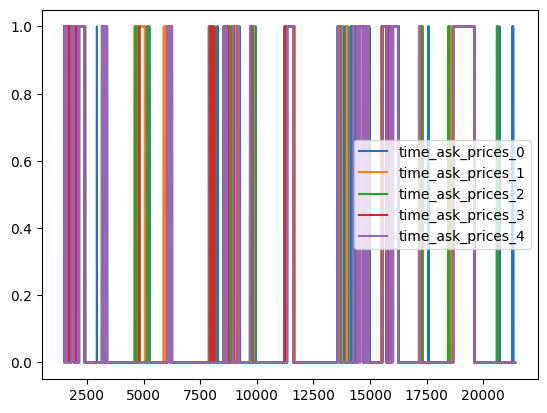

In [8]:
df[['time_' + col for col in columns if 'ask' in col]].iloc[N:len(df)//5].plot()
df[['time_' + col for col in columns if 'ask' in col]].iloc[N:len(df)//5].describe()

In [9]:
print('X shape :', X.shape)
print('Y shape :',Y.shape[0])

X shape : (19917, 501, 23)
Y shape : 19917


In [10]:
X_np = X.numpy()

# Now use train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_np, Y, test_size=0.2, shuffle=False)

In [11]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(Y_train.ravel()),  # Ensure Y_train is 1-dimensional
    y=Y_train.ravel()                    # Ensure Y_train is 1-dimensional
)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.7651267767960046, 1: 1.4429451186379278}

In [12]:
bias_initializer =  -np.log(np.count_nonzero(Y_train)/(len(Y_train)-np.count_nonzero(Y_train)))
bias_initializer

0.6343999838304114

In [14]:
class Model(Layer):
    def __init__(self, filters, kernel_size_Q, kernel_size_K, kernel_size_V, units, dilation_rate, num_heads):
        super(Model, self).__init__()
        self.units = units
        self.dilation_rate = dilation_rate

        # Dilated Convolution layers
        self.dilated_conv_Q = Conv1D(filters=filters, kernel_size=kernel_size_Q,
                                     dilation_rate=self.dilation_rate, padding='causal')
        self.dilated_conv_K = Conv1D(filters=filters, kernel_size=kernel_size_K,
                                     dilation_rate=self.dilation_rate, padding='causal')
        self.dilated_conv_V = Conv1D(filters=filters, kernel_size=kernel_size_V,
                                     dilation_rate=self.dilation_rate, padding='causal')
        
        # Max Pooling layer
        self.pooling = MaxPooling1D(pool_size=2, padding='valid')

        # Multi-Head Attention layer
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=units)

        # Layers after Multi-Head Attention
        self.flatten = Flatten()
        self.dense_layers = [Dense(units=32, activation='tanh') for _ in range(10)]
        self.attention_layers = [SeqSelfAttention(units=units, attention_activation='tanh',
                                                  attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL) 
                                 for _ in range(2)]

    def call(self, x):
        Q = self.dilated_conv_Q(x)
        Q = self.pooling(Q)
        K = self.dilated_conv_K(x)
        K = self.pooling(K)
        V = self.dilated_conv_V(x)
        V = self.pooling(V)

        # Multi-Head Attention
        x = self.multi_head_attention(Q, K, V)

        # Flatten and Reshape
        x = self.flatten(x)
        
        x = tf.expand_dims(x, -1)

        for i, layer in enumerate(self.dense_layers):
            x = layer(x)
            if (i + 1) % 5 == 0:
                x = self.attention_layers[i // 5](x)

        return x

In [15]:
def create_model(input_shape, filters, num_heads, dilation_rate, kernel_size_Q, kernel_size_K, kernel_size_V, units):
    return Model(filters=filters, kernel_size_Q=kernel_size_Q, kernel_size_K=kernel_size_K, 
                 kernel_size_V=kernel_size_V, dilation_rate=dilation_rate, num_heads=num_heads, units=units)

In [16]:
def create_full_model(input_shape, filters, num_heads, d_model, units, kernel_size_Q, kernel_size_K, 
                      kernel_size_V):
    encoder_inputs = layers.Input(shape=input_shape)
    model = create_model(input_shape, filters, num_heads, dilation_rate=1, 
                         kernel_size_Q=kernel_size_Q, kernel_size_K=kernel_size_K, 
                         kernel_size_V=kernel_size_V, units=d_model)
    translob_output = model(encoder_inputs)

    # Adding Flatten layer
    flat_output = tf.keras.layers.Flatten()(translob_output)

    # Final Dense layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid')(flat_output)

    # Create the full model
    full_model = tf.keras.models.Model(inputs=encoder_inputs, outputs=output)
    return full_model

In [17]:
print(X_train.shape, Y_train.shape)

(15933, 501, 23) (15933, 1)


In [18]:
# Define model parameters
input_shape = (N+1, 23)
output_shape = 1
filters = 2
units = 4
kernel_size_Q, kernel_size_K, kernel_size_V = 2, 3, 4
num_heads = 3
d_model = 2
batch = 16

In [ ]:
# Create the model
model = create_full_model(input_shape, filters, num_heads, d_model, units, 
                          kernel_size_Q, kernel_size_K, kernel_size_V)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=10**(-6)),
              loss='binary_crossentropy',
              metrics=[Accuracy(name='accuracy'),
                       Precision(name='precision'),
                       Recall(name='recall'),
                       AUC(name='auc')])

# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
model.fit(x=X_train, y=Y_train, batch_size=batch, epochs=100, callbacks=[callback],class_weight=class_weights_dict)

Epoch 1/100


2023-12-30 06:31:49.611449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


530/996 [==============>...............] - ETA: 31s - loss: 0.6934 - accuracy: 0.0000e+00 - precision: 0.3422 - recall: 0.6456 - auc: 0.5000

In [ ]:
Y_pred = model.predict(X_test)

plt.plot(Y_pred, label='pred')
plt.plot(Y_test, label='test')
plt.legend()

# Training Visualization

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=10**(-4))
loss_fn = tf.keras.losses.BinaryCrossentropy()

@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, gradients

def plot_distribution(data, title):
    plt.hist(data.flatten(), bins=50)
    plt.title(title)
    plt.show()

# Assuming X and Y are your data and labels
for epoch in range(10):
    for step in range(0, len(X_train), batch):
        x_batch = X_train[step:step + batch]
        y_batch = Y_train[step:step + batch]

        loss, gradients = train_step(model, x_batch, y_batch)

        # Every N steps, visualize weights, activations, and gradients
        if step % 100 == 0:
            # Visualize weights and gradients
            for var, grad in zip(model.trainable_variables, gradients):
                plot_distribution(var.numpy(), f'Weights of {var.name}')
                plot_distribution(grad.numpy(), f'Gradients of {var.name}')

            # Visualize activations
            intermediate_model = tf.keras.Model(inputs=model.input, outputs=[layer.output for 
                                                                             layer in model.layers])
            activations = intermediate_model.predict(x_batch)
            for i, activation in enumerate(activations):
                plot_distribution(activation, f'Activation of layer {i+1}')

In [ ]:
# Optuna objective function
def objective(trial):
    # Suggest values for the hyperparameters
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8, 16])
    filters = trial.suggest_categorical('filters', [2, 4, 8, 16])
    units = trial.suggest_categorical('units', [1, 4, 8, 16, 32])
    kernel_size_Q = trial.suggest_categorical('kernel_size_Q', [2, 4, 8, 16])
    kernel_size_K = trial.suggest_categorical('kernel_size_K', [2, 4, 8, 16])
    kernel_size_V = trial.suggest_categorical('kernel_size_V', [2, 4, 8, 16])
    dilation_rate = trial.suggest_categorical('dilation_rate', [1, 2, 3, 4])
    d_model = trial.suggest_categorical('d_model', [1, 2, 4, 8, 32])
    batch = trial.suggest_categorical('batch', [4, 8, 16, 32])
    # Suggest learning rate

    # Create the model using the suggested values
    model = create_full_model(input_shape, filters, num_heads, d_model, units,
                              kernel_size_Q, kernel_size_K, kernel_size_V)

    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy',
              metrics=[Accuracy(name='accuracy'),
                       Precision(name='precision'),
                       Recall(name='recall'),
                       AUC(name='auc')])

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(batch_size = batch)

    callback = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=3)
    history = model.fit(train_ds, epochs=10, callbacks=[callback], verbose=1)

    val_loss = sum(history.history['auc'][-6:-1])/5
    return val_loss

# Optuna study
study = optuna.create_study(direction='maximize')  # 'minimize' if lower is better, 'maximize' otherwise
study.optimize(objective, n_trials=20)  # Adjust the number of trials

# Print the optimal hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
# Define model parameters
input_shape = (N+1, 23)
output_shape = Y.shape[1]
num_heads = trial.params['num_heads']
filters = trial.params['filters']
units = trial.params['units']
kernel_size_Q = trial.params['kernel_size_Q']
kernel_size_K = trial.params['kernel_size_K']
kernel_size_V = trial.params['kernel_size_V']
batch = trial.params['batch']
learning_rate = trial.params['learning_rate']
# Create the model
model = create_full_model(input_shape, filters, num_heads, d_model, output_shape, units,
                              kernel_size_Q, kernel_size_K, kernel_size_V)
# Create TensorFlow dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(batch_size=batch)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy')

# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
model.fit(train_ds, epochs=100, callbacks=[callback])

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
plt.plot(Y_pred, label='pred')
#plt.plot(Y_test, label='actual')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
# Create the model
toy_model = Sequential()

# Add a Flatten layer to reshape the input for Dense layers
toy_model.add(Flatten(input_shape=input_shape))

# Add the first Dense layer after flattening the input
toy_model.add(Dense(64, activation='relu'))

# Add 8 more hidden layers
for _ in range(8):
    toy_model.add(Dense(32, activation='relu'))

toy_model.add(SeqSelfAttention(units=1, attention_activation='sigmoid', 
                               attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL))
# Add the output layer with sigmoid activation for binary classification
toy_model.add(Dense(1, activation='sigmoid'))

# Compile the model
toy_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[Accuracy(), Precision(), Recall(), AUC()])

# Summary of the model
toy_model.summary()

# Fit the model
toy_model.fit(X_train, Y_train, epochs=100, batch_size=16, verbose=1, callbacks=[callback])

In [ ]:
explainer = shap.TreeExplainer(toy_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X,
    feature_names=X.columns,
    output_names=["Prediction"]
)

# Generate the waterfall plot for the first prediction
shap.waterfall_plot(shap_explanation[0])